# **SkimLit(NLP)**

we're going to be replicating the deep learning model behind the 2017 paper [PubMed 200k RCT: a Dataset for Sequenctial Sentence Classification in Medical Abstracts.](https://arxiv.org/abs/1710.06071)

The goal of the dataset was to explore the ability for NLP models to classify sentences which appear in sequential order.



## Confirm access to a GPU

In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-2d2e9831-0137-30a4-9c55-2aff875fc648)


## Get data

In [2]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [3]:
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


In [4]:
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [5]:
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

## Preprocess Data

In [6]:
def get_lines(filename):
  with open(filename, "r") as f:
    return f.readlines()

In [7]:
train_lines = get_lines(data_dir + "train.txt")
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [8]:
len(train_lines)

210040

In [9]:
def preprocess_text_with_line_numbers(filename):
  input_lines = get_lines(filename)
  abstract_lines = ""
  abstract_samples = []

  for line in input_lines:
    if line.startswith('###'):
      abstract_id = line
      abstract_lines = ""
    elif line.isspace():
      abstract_line_split = abstract_lines.splitlines()

      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {}
        target_text_split = abstract_line.split("\t")
        line_data["target"] = target_text_split[0]
        line_data["text"] = target_text_split[1].lower()
        line_data["line_number"] = abstract_line_number
        line_data["total_lines"] = len(abstract_line_split) - 1
        abstract_samples.append(line_data)
    else:
      abstract_lines += line
  return abstract_samples

In [10]:
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt")
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")
len(train_samples), len(val_samples), len(test_samples)

(180040, 30212, 30135)

In [11]:
train_samples[:12]

[{'line_number': 0,
  'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_lines': 11},
 {'line_number': 1,
  'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'total_lines': 11},
 {'line_number': 2,
  'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'total_lines': 11},
 {'line_number': 3,
  'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'total_lines': 11},
 {'line_number': 4,
  'target': 'METHODS',
  'text': 'secondary outcome measures include

In [12]:
import pandas as pd

train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

In [13]:
train_df[:10]

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [14]:
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

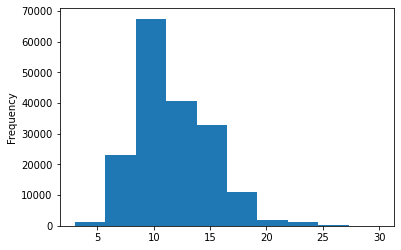

In [15]:
train_df.total_lines.plot.hist();

### Get list sentences

In [16]:
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

## Make numeric labels (ML model require numeric labels)

We're going to create one hot and label encoded labels.

In [17]:
from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.fit_transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.fit_transform(test_df["target"].to_numpy().reshape(-1, 1))

train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [18]:
import tensorflow as tf
tf.constant(train_labels_one_hot)

<tf.Tensor: shape=(180040, 5), dtype=float64, numpy=
array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])>

### Label encode labels

In [19]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.fit_transform(val_df["target"].to_numpy())
test_labels_encode = label_encoder.fit_transform(test_df["target"].to_numpy())

train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [20]:
num_classes = len(label_encoder.classes_)
class_name = label_encoder.classes_
num_classes, class_name

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Starting a series of modelling experiments...

##Model 0: Getting a baseline

In [21]:
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer

In [22]:
model_0 = Pipeline([
  ("tf-idf", TfidfVectorizer()),
  ("clf", MultinomialNB())
])

model_0.fit(X=train_sentences,
            y=train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [23]:
model_0.score(X=val_sentences,
                 y=val_labels_encoded)

0.7218323844829869

In [24]:
baseline_preds = model_0.predict(val_sentences)

In [25]:
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [26]:
def calculate_results(y_true, y_pred):
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

In [28]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
baseline_results = calculate_results(y_true=val_labels_encoded,
                                     y_pred=baseline_preds)

In [29]:
baseline_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

## Preparing our data (the text) for deep sequence models

In [30]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [31]:
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

(array([4.2075e+04, 8.3771e+04, 3.6877e+04, 1.0945e+04, 3.9310e+03,
        1.4450e+03, 5.6000e+02, 2.2600e+02, 1.0100e+02, 4.5000e+01,
        2.0000e+01, 1.2000e+01, 9.0000e+00, 1.0000e+01, 6.0000e+00,
        2.0000e+00, 3.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([  1.  ,  15.75,  30.5 ,  45.25,  60.  ,  74.75,  89.5 , 104.25,
        119.  , 133.75, 148.5 , 163.25, 178.  , 192.75, 207.5 , 222.25,
        237.  , 251.75, 266.5 , 281.25, 296.  ]),
 <a list of 20 Patch objects>)

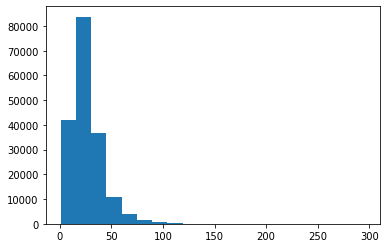

In [32]:
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=20)

In [33]:
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

### Create text vectorizer layer

In [34]:
max_tokens = 68000

In [35]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer = TextVectorization(max_tokens=max_tokens,
                                    output_sequence_length=output_seq_len)


In [36]:
text_vectorizer.adapt(train_sentences)

In [37]:
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized text: {text_vectorizer([target_sentence])}")

Text:
we determined the association between intraoperative blood loss and pelvic venous pressure as well as factors affecting pelvic venous pressure .

Length of text: 21

Vectorized text: [[  43  505    2  423   30  842  107  264    3 1742 1120  200   25  221
    25  254 2700 1742 1120  200    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]


In [38]:
rct_20k_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocab:  {len(rct_20k_vocab)}"),
print(f"Most common words in the vocab: {rct_20k_vocab[:5]}")
print(f"Least common words in the vocab: {rct_20k_vocab[-5:]}")

Number of words in vocab:  64841
Most common words in the vocab: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocab: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [39]:
text_vectorizer.get_config()

{'batch_input_shape': (None,),
 'dtype': 'string',
 'idf_weights': None,
 'max_tokens': 68000,
 'name': 'text_vectorization',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'ragged': False,
 'sparse': False,
 'split': 'whitespace',
 'standardize': 'lower_and_strip_punctuation',
 'trainable': True,
 'vocabulary': None}

### Create custom text embedding

To create a richer numerical representation of our text, we can use an embedding.

In [41]:
token_embed = layers.Embedding(input_dim=len(rct_20k_vocab),
                               output_dim=128,
                               mask_zero=True,
                               name="token_embedding")

In [42]:
print(f"Sentence before vecorization:\n{target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n {vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n {embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vecorization:
we determined the association between intraoperative blood loss and pelvic venous pressure as well as factors affecting pelvic venous pressure .

Sentence after vectorization (before embedding):
 [[  43  505    2  423   30  842  107  264    3 1742 1120  200   25  221
    25  254 2700 1742 1120  200    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]

Sentence after embedding:
 [[[-0.02614955 -0.02440631 -0.01652191 ... -0.03188612 -0.04623307
    0.02083007]
  [ 0.01849072 -0.01255579 -0.01969345 ...  0.01099993  0.00246358
    0.00214995]
  [-0.02081041 -0.02143333  0.00398231 ...  0.01894857 -0.04099143
   -0.01867361]
  ...
  [ 0.03674089  0.01986251 -0.03839368 ...  0.02505285 -0.02221983
    0.01757953]
  [ 0.03674089  0.01986251 -0.03839368 ...  0.02505285 -0.02221983
    0.01757953]
  [ 0.03674089  0.01986251 -0.03839368 .

## Creating datasets (making sure our data loads as fast as possible)

In [75]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [76]:
train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [77]:
train_labels_one_hot.shape, train_labels_one_hot[0]

((180040, 5), array([0., 0., 0., 1., 0.]))

In [78]:
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [79]:
train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

## Model 1: Conv1D with token embeddings

In [80]:
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs) 
token_embeddings = token_embed(text_vectors) 
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs)

model_1.compile(loss="categorical_crossentropy", 
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [81]:
model_1.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d_3 (Conv1D)           (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d_3   (None, 64)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_3 (Dense)             (None, 5)                 325 

In [82]:
train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [83]:
valid_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [84]:
# Fit the model
model_1_history = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1 * len(train_dataset)), # only fit on 10% of batches for faster training time
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1 * len(valid_dataset))) # only validate on 10% of batches

Epoch 1/3
562/562 [==============================] - 16s 9ms/step - loss: 0.9249 - accuracy: 0.6352 - val_loss: 0.6911 - val_accuracy: 0.7390
Epoch 2/3
562/562 [==============================] - 5s 8ms/step - loss: 0.6592 - accuracy: 0.7553 - val_loss: 0.6297 - val_accuracy: 0.7736
Epoch 3/3
562/562 [==============================] - 5s 8ms/step - loss: 0.6199 - accuracy: 0.7747 - val_loss: 0.5985 - val_accuracy: 0.7852


In [85]:
model_1.evaluate(valid_dataset)

945/945 [==============================] - 3s 3ms/step - loss: 0.6010 - accuracy: 0.7845


[0.60096675157547, 0.7845227122306824]

In [86]:
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs

array([[3.9943323e-01, 2.0880465e-01, 7.6030761e-02, 2.7763849e-01,
        3.8092915e-02],
       [4.7393930e-01, 2.5631133e-01, 1.0330263e-02, 2.5287208e-01,
        6.5469458e-03],
       [1.3653886e-01, 8.0655525e-03, 1.1895999e-03, 8.5417086e-01,
        3.5091591e-05],
       ...,
       [2.6471271e-06, 7.2209252e-04, 5.9640879e-04, 2.9701857e-06,
        9.9867588e-01],
       [5.0112180e-02, 4.5935532e-01, 9.6905671e-02, 7.5740911e-02,
        3.1788588e-01],
       [1.9966508e-01, 6.6104227e-01, 3.0484766e-02, 5.1397178e-02,
        5.7410695e-02]], dtype=float32)

In [87]:
model_1_pred_probs.shape

(30212, 5)

In [88]:
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [89]:
model_1_results = calculate_results(val_labels_encoded,
                                    model_1_preds)
model_1_results

{'accuracy': 78.45227062094531,
 'f1': 0.782000953532143,
 'precision': 0.7813099645300272,
 'recall': 0.7845227062094532}

## Model 2: Feature extraction with pretrained token embeddings

In [90]:
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [91]:
random_train_sentence = random.choice(train_sentences)
print(f"Random sentence:\n {random_train_sentence}")
use_embedded_sentence = tf_hub_embedding_layer([random_train_sentence])
print(f"Sentence after embedding:\n {use_embedded_sentence[0][:30]}\n")
print(f"Length of sentence embedding: {len(use_embedded_sentence[0])}")

Random sentence:
 in all other studies , subjects received polyethylene oxide-based tapentadol er tablets .
Sentence after embedding:
 [ 0.00818502  0.07975657 -0.02796623 -0.00863529 -0.02190973  0.03396842
  0.07007927  0.01724205 -0.08384561 -0.0275117   0.04446924 -0.02032147
  0.06047133  0.06384829 -0.06279483 -0.06629849 -0.07493319  0.06630018
 -0.04600175 -0.08534348  0.00109602  0.00622012 -0.0687167  -0.00388726
  0.0057718  -0.01040516  0.07705531  0.00212718  0.00938297  0.03827998]

Length of sentence embedding: 512


## Builing and fitting an NLP feature extraction model using pretrained embeddings Tensorflow Hub

In [92]:
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs)
x = layers.Dense(128, activation="relu")(pretrained_embedding)
outputs = layers.Dense(5, activation="softmax")(x)
model_2 = tf.keras.Model(inputs, outputs, name="model_2_USE_feature_extractor")

model_2.compile(loss="categorical_crossentropy",
                optimizer="Adam",
                metrics=["accuracy"])

In [93]:
model_2.summary()

Model: "model_2_USE_feature_extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_4 (Dense)             (None, 128)               65664     
                                                                 
 dense_5 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [94]:
history_model_2 = model_2.fit(train_dataset,
                              epochs=3,
                              steps_per_epoch=int(0.1 * len(train_dataset)),
                              validation_data=valid_dataset,
                              validation_steps=int(0.1 * len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 9s 13ms/step - loss: 0.9136 - accuracy: 0.6530 - val_loss: 0.7962 - val_accuracy: 0.6878
Epoch 2/3
562/562 [==============================] - 7s 12ms/step - loss: 0.7702 - accuracy: 0.7005 - val_loss: 0.7571 - val_accuracy: 0.7005
Epoch 3/3
562/562 [==============================] - 14s 25ms/step - loss: 0.7553 - accuracy: 0.7107 - val_loss: 0.7426 - val_accuracy: 0.7128


In [95]:
model_2.evaluate(valid_dataset)

945/945 [==============================] - 11s 12ms/step - loss: 0.7442 - accuracy: 0.7120


[0.7442370653152466, 0.7120018601417542]

In [96]:
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

array([[4.0438455e-01, 3.9608872e-01, 2.2842968e-03, 1.8938243e-01,
        7.8600282e-03],
       [2.9721376e-01, 5.3978944e-01, 2.8586285e-03, 1.5637206e-01,
        3.7660811e-03],
       [2.6033881e-01, 1.3575590e-01, 1.6736075e-02, 5.4889637e-01,
        3.8272887e-02],
       ...,
       [1.9352983e-03, 6.1981510e-03, 5.1371228e-02, 9.2100631e-04,
        9.3957436e-01],
       [3.9780769e-03, 3.8337067e-02, 2.1672499e-01, 1.3025554e-03,
        7.3965728e-01],
       [1.8336768e-01, 2.4516767e-01, 5.0420278e-01, 6.7558382e-03,
        6.0506005e-02]], dtype=float32)

In [97]:
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [98]:
model_2_results = calculate_results(val_labels_encoded,
                                    model_2_preds)

In [99]:
model_2_results

{'accuracy': 71.20018535681186,
 'f1': 0.7089198408366516,
 'precision': 0.7124022983588013,
 'recall': 0.7120018535681186}

In [100]:
model_1_results

{'accuracy': 78.45227062094531,
 'f1': 0.782000953532143,
 'precision': 0.7813099645300272,
 'recall': 0.7845227062094532}

 ## Model 3: Conv1D with character embeddings

### Creating character-level tokenizer

In [101]:
train_sentences[:15]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

In [102]:
def split_chare(text):
  return " ".join(list(text))

split_chare(random_train_sentence)

'i n   a l l   o t h e r   s t u d i e s   ,   s u b j e c t s   r e c e i v e d   p o l y e t h y l e n e   o x i d e - b a s e d   t a p e n t a d o l   e r   t a b l e t s   .'

In [103]:
train_chars = [split_chare(sentence) for sentence in train_sentences]
val_chars = [split_chare(sentence) for sentence in val_sentences]
test_chars = [split_chare(sentence) for sentence in test_sentences]

train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [104]:
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

(array([1.41175e+05, 3.71110e+04, 1.60000e+03, 1.27000e+02, 2.10000e+01,
        5.00000e+00, 1.00000e+00]),
 array([1.00000000e+00, 1.98857143e+02, 3.96714286e+02, 5.94571429e+02,
        7.92428571e+02, 9.90285714e+02, 1.18814286e+03, 1.38600000e+03]),
 <a list of 7 Patch objects>)

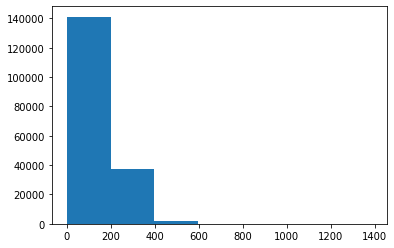

In [105]:
import matplotlib.pyplot as plt
plt.hist(char_lens, bins=7)

In [106]:
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [107]:
random.choice(train_sentences)

'one hundred and twenty cases of thoracic surgery were randomly divided into an electroacupuncture ( ea ) group ( @ cases ) and a medication group ( @ cases ) .'

In [108]:
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [109]:
NUM_CHAR_TOKENS = len(alphabet)
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=output_seq_char_len,
                                   # standardize=None,
                                    name="char_vectorizer")

In [110]:
char_vectorizer.adapt(train_chars)

In [111]:
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [112]:
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n {random_train_chars}")
print(f"\nLength of random_train_chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n {vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars)}")

Charified text:
 a t   p r e s e n t   t h e   o n l y   v a l i d a t e d   t e s t   i s   t h e   i p s s - q @   ,   b u t   i n   i t a l y   i t   i s   u s e d   b y   o n l y   @   %   o f   g e n e r a l   p r a c t i t i o n e r s   (   g p s   )   .

Length of random_train_chars: 96

Vectorized chars:
 [[ 5  3 14  8  2  9  2  6  3  3 13  2  7  6 12 19 21  5 12  4 10  5  3  2
  10  3  2  9  3  4  9  3 13  2  4 14  9  9 26 22 16  3  4  6  4  3  5 12
  19  4  3  4  9 16  9  2 10 22 19  7  6 12 19  7 17 18  2  6  2  8  5 12
  14  8  5 11  3  4  3  4  7  6  2  8  9 18 14  9  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0

## Creating a character embedding layer

In [113]:
char_embed = layers.Embedding(input_dim=len(char_vocab),
                              output_dim=24,
                              mask_zero=True,
                              name="char_embed")

In [114]:
print(f"Charified text:\n {random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars (after vectorizetionand embedding):\n\n {char_embed_example}")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text:
 a t   p r e s e n t   t h e   o n l y   v a l i d a t e d   t e s t   i s   t h e   i p s s - q @   ,   b u t   i n   i t a l y   i t   i s   u s e d   b y   o n l y   @   %   o f   g e n e r a l   p r a c t i t i o n e r s   (   g p s   )   .

Embedded chars (after vectorizetionand embedding):

 [[[ 0.04304901  0.02536234  0.02893516 ...  0.03866619 -0.03234534
   -0.03185515]
  [-0.04774065 -0.03894448  0.01759749 ...  0.04537265 -0.02095645
    0.01520455]
  [ 0.00567191 -0.01402413 -0.04789465 ... -0.01802839  0.0362998
    0.04541758]
  ...
  [-0.01921184 -0.02114194  0.00511608 ...  0.02712144  0.04855916
    0.04261518]
  [-0.01921184 -0.02114194  0.00511608 ...  0.02712144  0.04855916
    0.04261518]
  [-0.01921184 -0.02114194  0.00511608 ...  0.02712144  0.04855916
    0.04261518]]]
Character embedding shape: (1, 290, 24)


### Building a Conv1D model model to fit on character embeddings

In [115]:
inputs = layers.Input(shape=(1, ), dtype="string")
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(char_embeddings)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_3_conv1D_char_embeddings")

model_3.compile(loss="categorical_crossentropy",
                optimizer="Adam",
                metrics=["accuracy"])

In [116]:
model_3.summary()

Model: "model_3_conv1D_char_embeddings"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 290)              0         
 ization)                                                        
                                                                 
 char_embed (Embedding)      (None, 290, 24)           672       
                                                                 
 conv1d_4 (Conv1D)           (None, 290, 64)           7744      
                                                                 
 global_average_pooling1d_4   (None, 64)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_6 (Dense)             (None, 

In [117]:
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

In [118]:
train_char_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [119]:
model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_dataset)),
                              epochs=3,
                              validation_data=val_char_dataset,
                              validation_steps=int(0.1 * len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 4s 6ms/step - loss: 1.4610 - accuracy: 0.3489 - val_loss: 1.4047 - val_accuracy: 0.4036
Epoch 2/3
562/562 [==============================] - 3s 5ms/step - loss: 1.3594 - accuracy: 0.4305 - val_loss: 1.3277 - val_accuracy: 0.4435
Epoch 3/3
562/562 [==============================] - 3s 5ms/step - loss: 1.3210 - accuracy: 0.4520 - val_loss: 1.3144 - val_accuracy: 0.4405


In [120]:
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

array([[0.17940551, 0.23407194, 0.28096983, 0.16428111, 0.14127164],
       [0.10589567, 0.15631993, 0.17187552, 0.06080345, 0.50510544],
       [0.10225275, 0.15925361, 0.41861045, 0.10595726, 0.21392588],
       ...,
       [0.05555801, 0.10365062, 0.23369849, 0.04410119, 0.56299174],
       [0.03862467, 0.09082762, 0.16608356, 0.04336317, 0.661101  ],
       [0.14445584, 0.17892271, 0.18853046, 0.07235939, 0.41573164]],
      dtype=float32)

In [121]:
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([2, 4, 2, ..., 4, 4, 4])>

In [122]:
model_3_results = calculate_results(val_labels_encoded, 
                                    model_3_preds)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [123]:
model_3_results

{'accuracy': 44.813319210909576,
 'f1': 0.3918431214427503,
 'precision': 0.37564362576193633,
 'recall': 0.44813319210909575}

## Model 4: Combining pretrained token embedding + characters embeddings (hybrid embedding layer)

In [124]:
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

char_inputs = layers.Input(shape=(1, ), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(25))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

token_char_concat = layers.Concatenate(name="token_char_concatenet")([token_model.output,
                                                                      char_model.output])

combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128, activation="relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_4_token_and_char_embeddings")

In [125]:
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   [

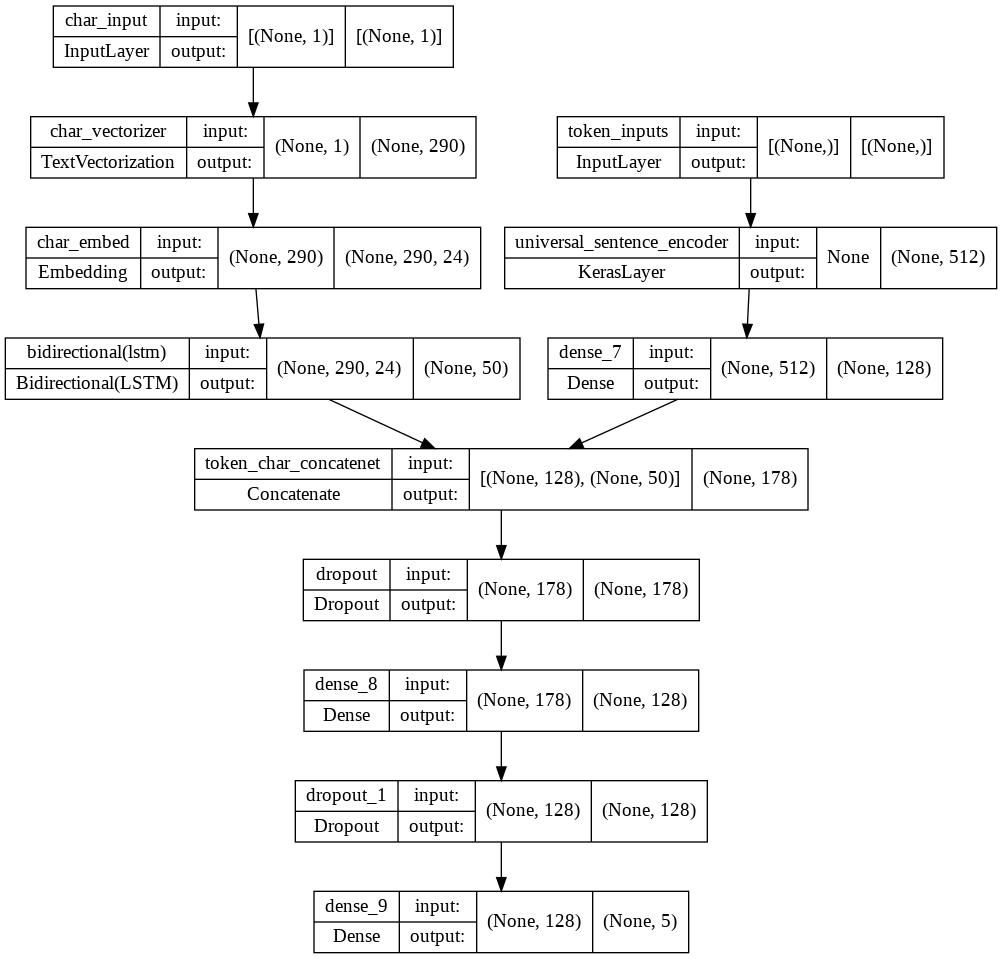

In [126]:
from tensorflow.keras.utils import plot_model
plot_model(model_4, show_shapes=True)

In [127]:
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

### Combining token and character data into tf.data.Datset

In [128]:
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars))
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels))

train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [129]:
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))

val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [130]:
train_char_token_dataset, val_char_token_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [131]:
model_4_history = model_4.fit(train_char_token_dataset,
                              epochs=3,
                              steps_per_epoch=int(0.1 * len(train_char_token_dataset)),
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1 * len(val_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 40s 56ms/step - loss: 0.9838 - accuracy: 0.6094 - val_loss: 0.7927 - val_accuracy: 0.6902
Epoch 2/3
562/562 [==============================] - 27s 48ms/step - loss: 0.8034 - accuracy: 0.6917 - val_loss: 0.7256 - val_accuracy: 0.7231
Epoch 3/3
562/562 [==============================] - 24s 43ms/step - loss: 0.7839 - accuracy: 0.7006 - val_loss: 0.6983 - val_accuracy: 0.7324


In [132]:
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 22s 24ms/step - loss: 0.7004 - accuracy: 0.7328


[0.7004426121711731, 0.7327883243560791]

In [133]:
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs

array([[4.0886334e-01, 3.9717951e-01, 8.8087013e-03, 1.7752220e-01,
        7.6263105e-03],
       [3.4592861e-01, 4.5496085e-01, 4.2482098e-03, 1.9353803e-01,
        1.3243208e-03],
       [2.2485742e-01, 1.1127013e-01, 3.7434276e-02, 6.0190654e-01,
        2.4531638e-02],
       ...,
       [6.1757892e-04, 5.6271995e-03, 5.1395230e-02, 2.7879499e-04,
        9.4208127e-01],
       [1.0980209e-02, 7.6151736e-02, 2.7833709e-01, 4.9729547e-03,
        6.2955803e-01],
       [2.9975384e-01, 3.6132878e-01, 2.3606268e-01, 3.6572453e-02,
        6.6282205e-02]], dtype=float32)

In [134]:
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 1])>

In [135]:
model_4_results = calculate_results(val_labels_encoded,
                                    model_4_preds)

In [136]:
model_4_results

{'accuracy': 73.2788296041308,
 'f1': 0.7296412498156217,
 'precision': 0.7337675124365082,
 'recall': 0.7327882960413081}

## Model 5: Transfer learning with pretrained token embeddings + character embeedding + positional embeddings

In [137]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


### Create positional embeddings

In [138]:
len(train_df["line_number"])

180040

In [139]:
train_df["line_number"].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

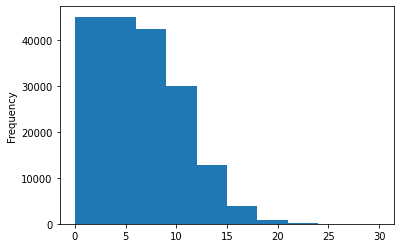

In [140]:
train_df.line_number.plot.hist()

In [141]:
train_line_number_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
val_line_number_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_number_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)

test_line_number_one_hot[:15], test_line_number_one_hot.shape

(<tf.Tensor: shape=(15, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0.

In [142]:
train_df["total_lines"].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

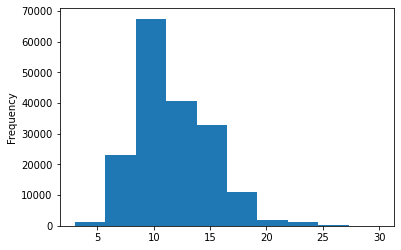

In [143]:
train_df["total_lines"].plot.hist()

In [144]:
np.percentile(train_df.total_lines, 98)

20.0

In [145]:
train_total_line_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_line_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_line_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)

In [146]:
train_total_line_one_hot[:20]

<tf.Tensor: shape=(20, 20), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
     

### Building a tribrid embedding model

In [147]:
# 1. Token inputs
token_inputs = layers.Input(shape=[], dtype="string", name="token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# 2. Char inputs
char_inputs = layers.Input(shape=(1,), dtype="string", name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(32))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Line numbers inputs
line_number_inputs = layers.Input(shape=(15,), dtype=tf.int32, name="line_number_input")
x = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs=x)

# 4. Total lines inputs
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.int32, name="total_lines_input")
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_line_model = tf.keras.Model(inputs=total_lines_inputs,
                                  outputs=y)

# 5. Combine token and char embeddings into a hybrid embedding
combined_embeddings = layers.Concatenate(name="token_char_hybrid_embedding")([token_model.output, 
                                                                              char_model.output])
z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6. Combine positional embeddings with combined token and char embeddings into a tribrid embedding
z = layers.Concatenate(name="token_char_positional_embedding")([line_number_model.output,
                                                                total_line_model.output,
                                                                z])

# 7. Create output layer
output_layer = layers.Dense(5, activation="softmax", name="output_layer")(z)

# 8. Put together model
model_5 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_line_model.input,
                                 token_model.input, 
                                 char_model.input],
                         outputs=output_layer)

In [148]:
model_5.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['token_inputs[0][0]']    

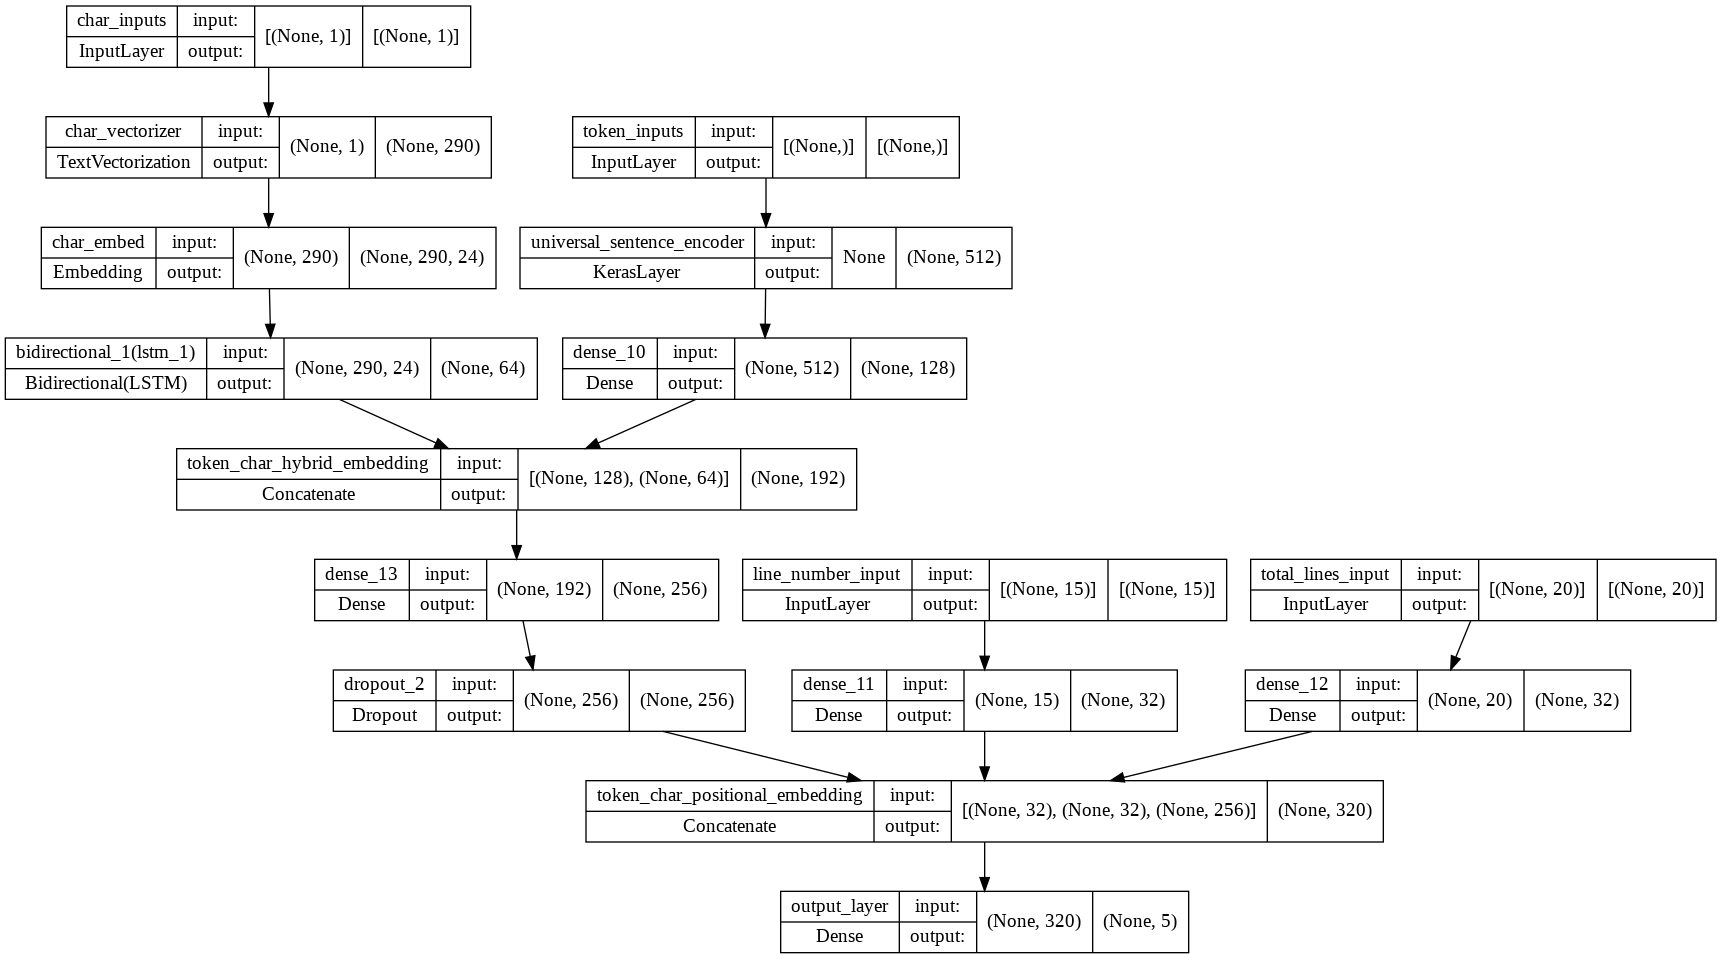

In [149]:
from tensorflow.keras.utils import plot_model
plot_model(model_5, show_shapes=True)

In [150]:
for layer in model_5.layers:
  print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f61a09a4750> True
<keras.engine.input_layer.InputLayer object at 0x7f61a10a3e50> True
<keras.layers.preprocessing.text_vectorization.TextVectorization object at 0x7f60c9506650> True
<tensorflow_hub.keras_layer.KerasLayer object at 0x7f618e132c50> False
<keras.layers.embeddings.Embedding object at 0x7f60c9540d90> True
<keras.layers.core.dense.Dense object at 0x7f61a198aa50> True
<keras.layers.wrappers.Bidirectional object at 0x7f61a103afd0> True
<keras.layers.merge.Concatenate object at 0x7f619fc930d0> True
<keras.engine.input_layer.InputLayer object at 0x7f61a101ce10> True
<keras.engine.input_layer.InputLayer object at 0x7f61a1108450> True
<keras.layers.core.dense.Dense object at 0x7f619fea6c50> True
<keras.layers.core.dense.Dense object at 0x7f61a198ff90> True
<keras.layers.core.dense.Dense object at 0x7f619fe2e090> True
<keras.layers.core.dropout.Dropout object at 0x7f619fbcbd10> True
<keras.layers.merge.Concatenate object at 0x7f619f

In [151]:
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # add label smoothing (examples which are really confident get smoothed a little)
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [152]:
train_pos_char_token_data = tf.data.Dataset.from_tensor_slices((train_line_number_one_hot,
                                                                train_total_line_one_hot,
                                                                train_sentences,
                                                                train_chars))
train_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_pos_char_token_dataset = tf.data.Dataset.zip((train_pos_char_token_data, train_pos_char_token_labels))
train_pos_char_token_dataset = train_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


val_pos_char_token_data = tf.data.Dataset.from_tensor_slices((val_line_number_one_hot,
                                                              val_total_line_one_hot,
                                                              val_sentences,
                                                              val_chars))
val_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_pos_char_token_dataset = tf.data.Dataset.zip((val_pos_char_token_data, val_pos_char_token_labels))
val_pos_char_token_dataset = val_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

train_pos_char_token_dataset, val_pos_char_token_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [153]:
model_5_history = model_5.fit(train_pos_char_token_dataset,
                              epochs=3,
                              steps_per_epoch=int(0.1 * len(train_pos_char_token_dataset)),
                              validation_data=val_pos_char_token_dataset,
                              validation_steps=int(0.1 * len(val_pos_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 38s 53ms/step - loss: 1.0976 - accuracy: 0.7231 - val_loss: 0.9847 - val_accuracy: 0.8055
Epoch 2/3
562/562 [==============================] - 27s 48ms/step - loss: 0.9678 - accuracy: 0.8149 - val_loss: 0.9514 - val_accuracy: 0.8275
Epoch 3/3
562/562 [==============================] - 26s 46ms/step - loss: 0.9505 - accuracy: 0.8227 - val_loss: 0.9398 - val_accuracy: 0.8308


In [154]:
model_5_pred_probs = model_5.predict(val_pos_char_token_dataset)
model_5_pred_probs

array([[0.5126196 , 0.1167663 , 0.01099005, 0.34296387, 0.01666014],
       [0.5013492 , 0.09840119, 0.039419  , 0.35005012, 0.01078043],
       [0.31498277, 0.11787434, 0.12561397, 0.37245038, 0.06907852],
       ...,
       [0.03109193, 0.10251546, 0.04360786, 0.03401364, 0.7887711 ],
       [0.03062978, 0.28320384, 0.08420265, 0.02443583, 0.5775279 ],
       [0.20618023, 0.6036769 , 0.08833433, 0.04037205, 0.0614365 ]],
      dtype=float32)

In [155]:
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [156]:
model_5_results = calculate_results(val_labels_encoded,
                                    model_5_preds)

In [157]:
model_5_results

{'accuracy': 83.31788693234476,
 'f1': 0.832169995483046,
 'precision': 0.8320146943358888,
 'recall': 0.8331788693234476}

### Compare all models

In [158]:
import pandas as pd
all_models_results = pd.DataFrame({"baseline": baseline_results,
                                   "model_1_custom_token_embedding": model_1_results,
                                   "model_2_pretrained_token_embedding": model_2_results,
                                   "model_3_custom_char_embedding": model_3_results,
                                   "model_4_hybrid_char_token_embedding": model_4_results,
                                   "model_5_pos_char_token_embedding": model_5_results})
all_models_results = all_models_results.transpose()
all_models_results

,accuracy,precision,recall,f1
baseline,72.183238,0.718647,0.721832,0.698925
model_1_custom_token_embedding,78.452271,0.781310,0.784523,0.782001
model_2_pretrained_token_embedding,71.200185,0.712402,0.712002,0.708920
model_3_custom_char_embedding,44.813319,0.375644,0.448133,0.391843
model_4_hybrid_char_token_embedding,73.278830,0.733768,0.732788,0.729641
model_5_pos_char_token_embedding,83.317887,0.832015,0.833179,0.832170


In [159]:
all_models_results["accuracy"] = all_models_results["accuracy"]/100

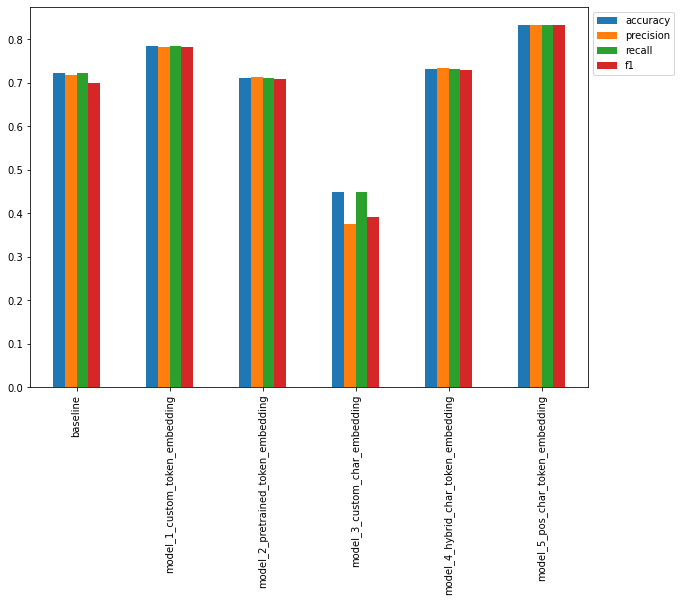

In [160]:
all_models_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0))

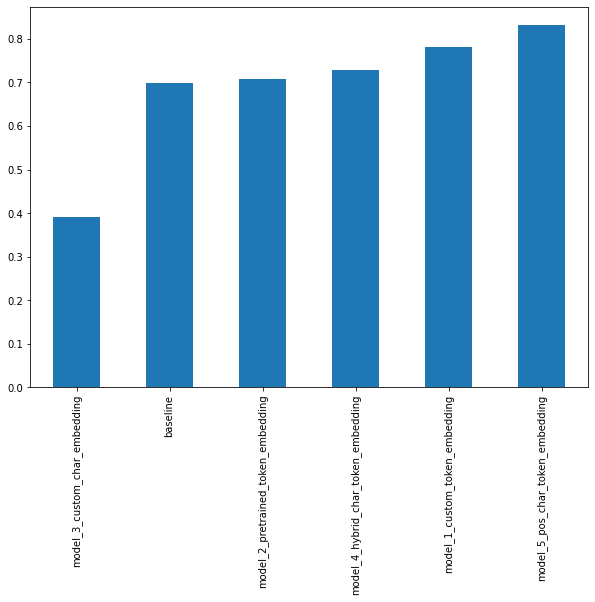

In [161]:
all_models_results.sort_values('f1', ascending=True)["f1"].plot(kind="bar", figsize=(10, 7));